# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, balanced_accuracy_score, make_scorer, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import time
warnings.filterwarnings("ignore")

# **Loading the dataset and cleaning it**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = "/content/drive/MyDrive/FloodPrediction.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [5]:
#converting nan values to 0
df['Flood?'] = df['Flood?'].replace('NaN', np.nan).fillna(0)

In [6]:
# For numerical columns filling with median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Flood?')

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled {col} with median")

In [7]:
# For categorical columns filling with mode
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)
        print(f"Filled {col} with mode")

In [8]:
# Cell 5: Remove duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows")

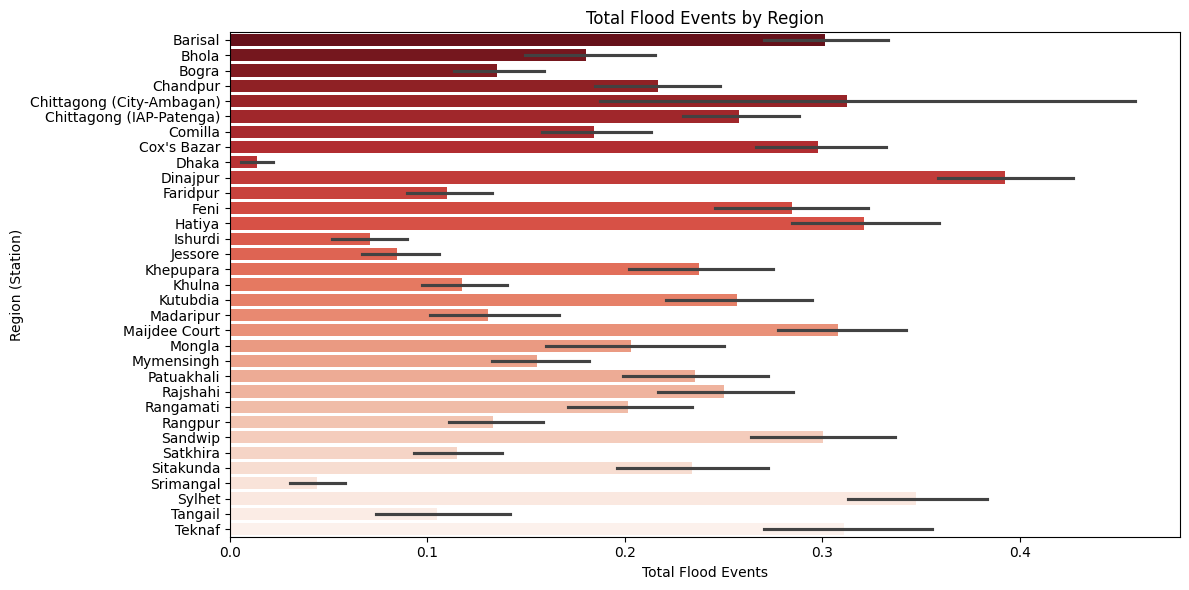

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Flood?", y="Station_Names", palette="Reds_r")
plt.title("Total Flood Events by Region")
plt.xlabel("Total Flood Events")
plt.ylabel("Region (Station)")
plt.tight_layout()
plt.show()

In [10]:
# Fixing humidity bounds (should be 0-100%)
if 'Relative_Humidity' in df.columns:
    out_of_bounds = ((df['Relative_Humidity'] < 0) | (df['Relative_Humidity'] > 100)).sum()
    if out_of_bounds > 0:
        df['Relative_Humidity'] = df['Relative_Humidity'].clip(0, 100)
        print(f"Fixed {out_of_bounds} humidity values out of bounds")

In [11]:
print(f"\nFinal shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Flood distribution: {df['Flood?'].value_counts().to_dict()}")
print("\nData cleaning completed, Ready for outlier detection.")


Final shape: (20544, 19)
Missing values: 0
Flood distribution: {0.0: 16412, 1.0: 4132}

Data cleaning completed, Ready for outlier detection.


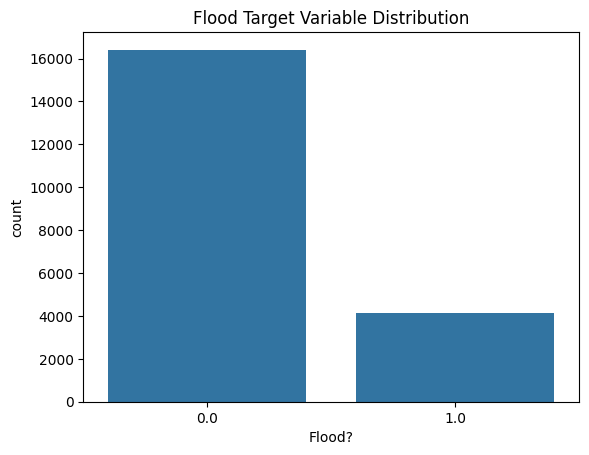

Flood?
0.0    0.798871
1.0    0.201129
Name: proportion, dtype: float64


In [12]:
sns.countplot(x='Flood?', data=df)
plt.title("Flood Target Variable Distribution")
plt.show()

print(df['Flood?'].value_counts(normalize=True))


# **Outlier Detection**

In [14]:
df_outliers = df.copy()
iqr_features = ['Rainfall', 'Wind_Speed']
zscore_features = ['Max_Temp', 'Min_Temp', 'Relative_Humidity',
                   'Cloud_Coverage', 'Bright_Sunshine']

# IQR Method for skewed features
for col in iqr_features:
    Q1 = df_outliers[col].quantile(0.25)
    Q3 = df_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df_outliers.shape[0]
    df_outliers = df_outliers[(df_outliers[col] >= lower) & (df_outliers[col] <= upper)]
    after = df_outliers.shape[0]
    print(f"{col} (IQR): Removed {before - after} outliers")

# Z-Score Method for near-normal features
from scipy.stats import zscore

for col in zscore_features:
    before = df_outliers.shape[0]
    z_scores = zscore(df_outliers[col])
    df_outliers = df_outliers[(np.abs(z_scores) < 3)]
    after = df_outliers.shape[0]
    print(f"{col} (Z-Score): Removed {before - after} outliers")

print("New shape after combined outlier removal:", df_outliers.shape)


Rainfall (IQR): Removed 697 outliers
Wind_Speed (IQR): Removed 875 outliers
Max_Temp (Z-Score): Removed 45 outliers
Min_Temp (Z-Score): Removed 0 outliers
Relative_Humidity (Z-Score): Removed 202 outliers
Cloud_Coverage (Z-Score): Removed 0 outliers
Bright_Sunshine (Z-Score): Removed 20 outliers
New shape after combined outlier removal: (18705, 19)


In [15]:
df_outliers.to_csv('cleaned_flood_prediction.csv', index=False)

# **Feature Engineering and Encoding**

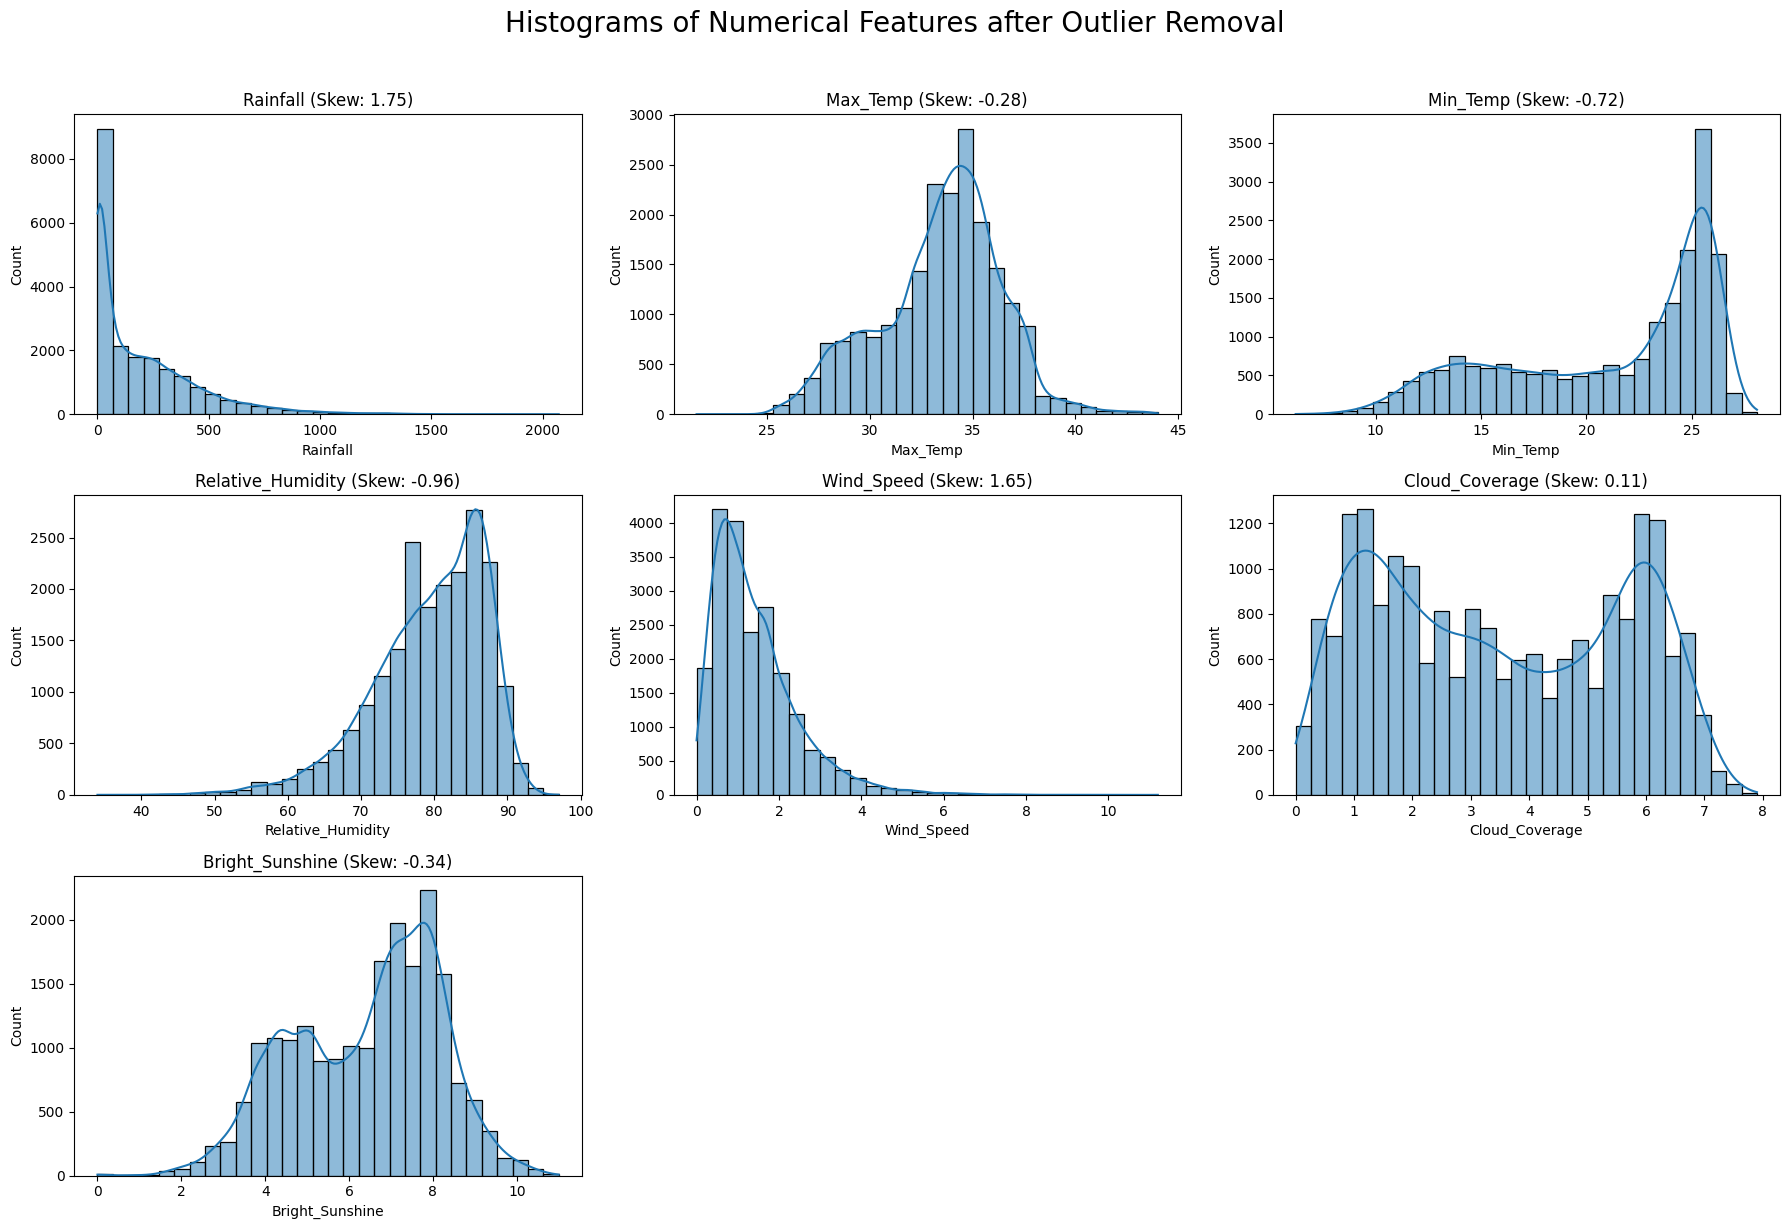

In [16]:
num_features = ['Rainfall', 'Max_Temp', 'Min_Temp', 'Relative_Humidity',
                'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine']

plt.figure(figsize=(18, 12))
plt.suptitle('Histograms of Numerical Features after Outlier Removal', fontsize=20, y=1.02)

for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} (Skew: {df[col].skew():.2f})')

plt.tight_layout()
plt.show()


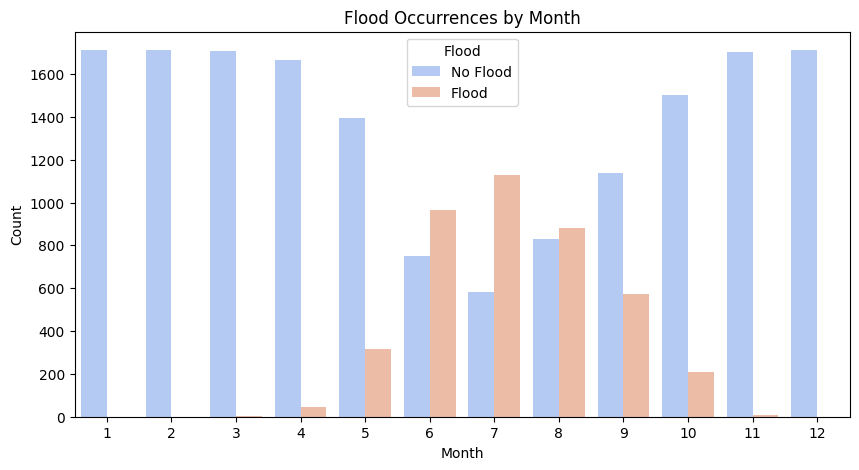

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Month', hue='Flood?', data=df, palette='coolwarm')
plt.title("Flood Occurrences by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title='Flood', labels=['No Flood', 'Flood'])
plt.show()

In [18]:
# Drop irrelevant columns
df_model = df_outliers.drop(['Sl', 'Station_Number', 'X_COR', 'Y_COR', 'Period'], axis=1)

# Log-transform Rainfall for skew correction
df_model['Rainfall_log'] = np.log1p(df_model['Rainfall'])
df_model.drop('Rainfall', axis=1, inplace=True)

In [19]:
#deriving seasons from months
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_model['Season'] = df_model['Month'].apply(get_season)
df_model.drop('Month', axis=1, inplace=True)

# One-hot encode Season
df_model = pd.get_dummies(df_model, columns=['Season'], drop_first=True)

# Label encode Station_Names
df_model['Station_Names'] = LabelEncoder().fit_transform(df_model['Station_Names'])

# Define features and target
features = [col for col in df_model.columns if col != 'Flood?']

X = df_model[features]
y = df_model['Flood?']

print(f"Features used: {features}")
print(f"Feature matrix shape: {X.shape}")

Features used: ['Station_Names', 'Year', 'Max_Temp', 'Min_Temp', 'Relative_Humidity', 'Wind_Speed', 'Cloud_Coverage', 'Bright_Sunshine', 'LATITUDE', 'LONGITUDE', 'ALT', 'Rainfall_log', 'Season_Spring', 'Season_Summer', 'Season_Winter']
Feature matrix shape: (18705, 15)


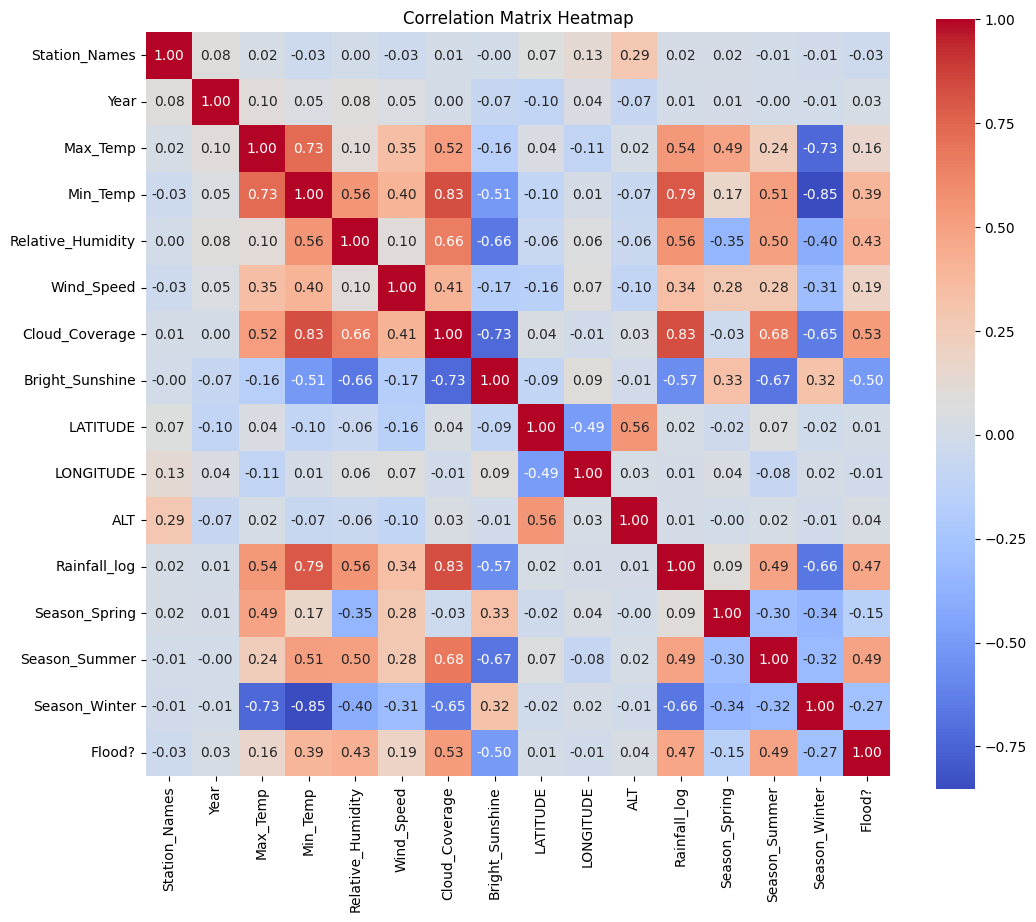

In [20]:
plt.figure(figsize=(12,10))
corr = df_model[features + ['Flood?']].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# **Train/Test Split and Scaling**

In [21]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Scale features only for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **VIF Check for Multicollinearity**

In [22]:
# VIF calculation on scaled features for Logistic Regression
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)

vif_data = pd.DataFrame()
vif_data['Feature'] = features
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(len(features))]

print("Variance Inflation Factors:")
print(vif_data.sort_values(by='VIF', ascending=False))

Variance Inflation Factors:
              Feature        VIF
3            Min_Temp  10.826623
6      Cloud_Coverage   8.198122
14      Season_Winter   4.839880
2            Max_Temp   3.811098
11       Rainfall_log   3.735625
7     Bright_Sunshine   3.239838
4   Relative_Humidity   2.845254
8            LATITUDE   2.584916
13      Season_Summer   2.404815
12      Season_Spring   2.261695
10                ALT   1.911829
9           LONGITUDE   1.696392
5          Wind_Speed   1.498707
0       Station_Names   1.128182
1                Year   1.093674


# **Balancing with SMOTE**

In [23]:
smote = SMOTE(random_state=42)
X_train_scaled_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"SMOTE applied. New training size: {X_train_scaled_smote.shape[0]} samples")

SMOTE applied. New training size: 24850 samples


# **Random Forest Classifier with serial training**

In [24]:
rf_serial = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=1  # Forces single-core training
)

rf_serial.fit(X_train, y_train)

y_pred_rf_serial = rf_serial.predict(X_test)
y_proba_rf_serial = rf_serial.predict_proba(X_test)[:, 1]

# SERIAL timing
start_time = time.time()
rf_serial.fit(X_train, y_train)
serial_time = time.time() - start_time
print(f"Serial training time: {serial_time:.2f} seconds")

Serial training time: 2.08 seconds


# **Random Forest Classifier with Parallel training**

In [25]:
rf_parallel = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Uses all cores
)

rf_parallel.fit(X_train, y_train)

y_pred_rf_parallel = rf_parallel.predict(X_test)
y_proba_rf_parallel = rf_parallel.predict_proba(X_test)[:, 1]

# PARALLEL timing
start_time = time.time()
rf_parallel.fit(X_train, y_train)
parallel_time = time.time() - start_time
print(f"Parallel training time: {parallel_time:.2f} seconds")

Parallel training time: 1.11 seconds


# **Logistic Regression**

In [26]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled_smote, y_train_smote)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# **Evaluation Metrics**

In [27]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"{model_name} ")
    print(classification_report(y_true, y_pred))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Balanced Accuracy:", balanced_accuracy_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))

    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ROC Curve
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[1].set_title(f"{model_name} ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# **Evaluation Metrics for Random Forest Classifier**

Random Forest (Parallel) 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3106
         1.0       0.93      0.92      0.92       635

    accuracy                           0.97      3741
   macro avg       0.96      0.95      0.95      3741
weighted avg       0.97      0.97      0.97      3741

Precision: 0.9327
Recall: 0.9165
Balanced Accuracy: 0.9515066090016275
ROC-AUC: 0.9945485243191993


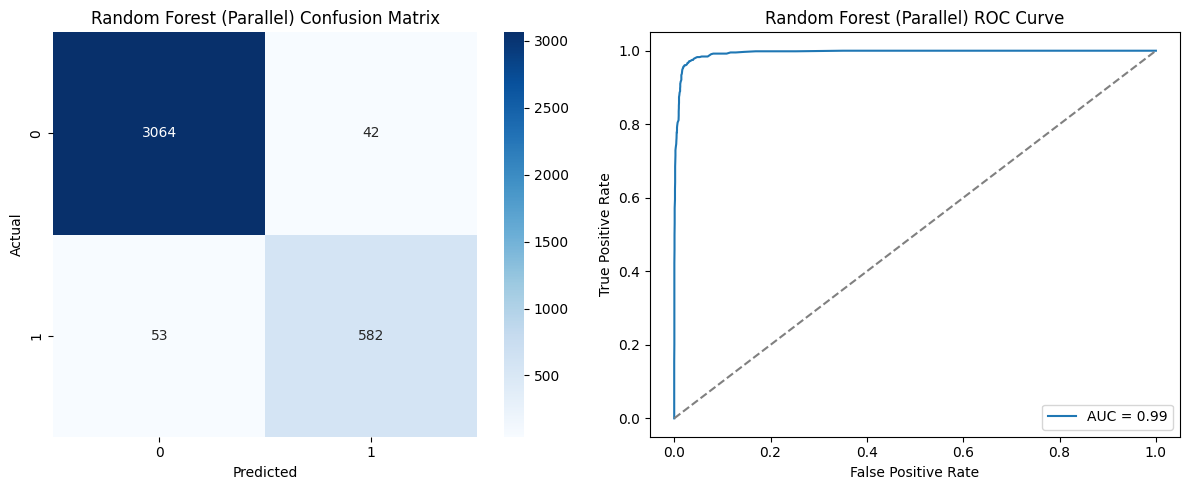

In [28]:
evaluate_model(y_test, y_pred_rf_parallel, y_proba_rf_parallel, "Random Forest (Parallel)")

Random Forest (Serial) 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      3106
         1.0       0.93      0.92      0.92       635

    accuracy                           0.97      3741
   macro avg       0.96      0.95      0.95      3741
weighted avg       0.97      0.97      0.97      3741

Precision: 0.9327
Recall: 0.9165
Balanced Accuracy: 0.9515066090016275
ROC-AUC: 0.9945485243191993


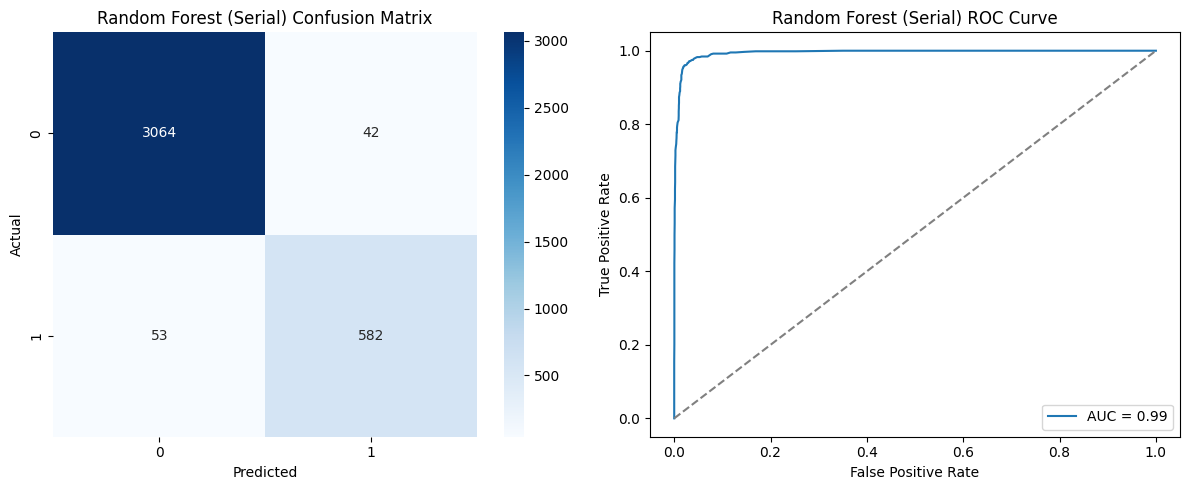

In [29]:
evaluate_model(y_test, y_pred_rf_parallel, y_proba_rf_parallel, "Random Forest (Serial)")

# **Evaluation Metrics for Logistic Regression**

Logistic Regression 
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95      3106
         1.0       0.69      0.96      0.80       635

    accuracy                           0.92      3741
   macro avg       0.84      0.93      0.87      3741
weighted avg       0.94      0.92      0.92      3741

Precision: 0.6862
Recall: 0.9575
Balanced Accuracy: 0.9339880647565545
ROC-AUC: 0.9794834483422991


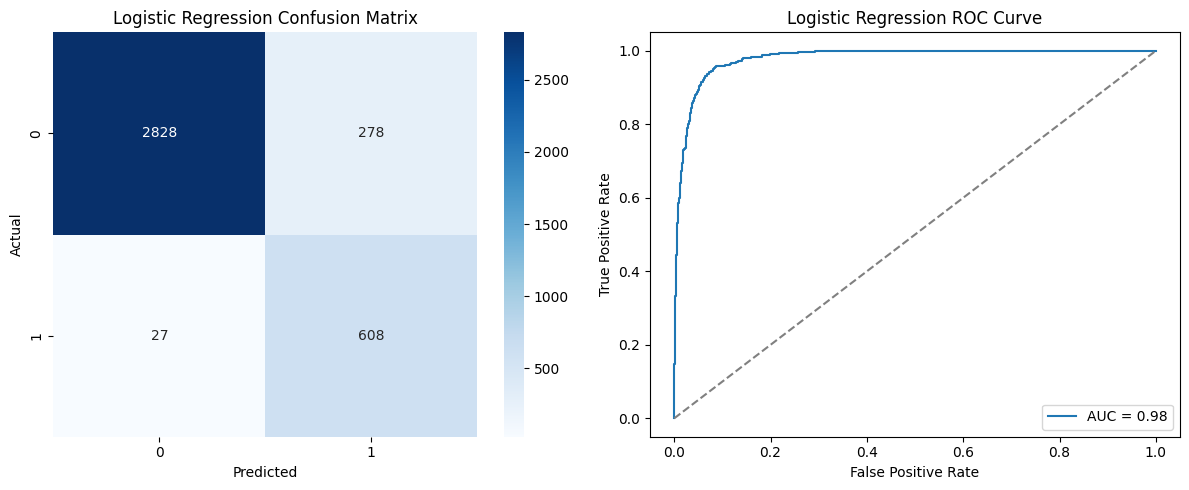

In [30]:
evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")

# **Stratified K-Fold Cross-Validation with Mean F1 for Random Forest with Serial Computing**

In [41]:
# Define multiple scorers
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SERIAL
rf_serial = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    n_jobs=1,
    random_state=42
)

start_time = time.time()
rf_cv_serial = cross_validate(
    rf_serial, X, y, cv=kf, scoring=scoring, n_jobs=1
)
serial_time = time.time() - start_time

print("Random Forest Cross-Validation (Serial, n_jobs=1):")
print(f"F1 scores: {rf_cv_serial['test_f1']}")
print(f"Precision scores: {rf_cv_serial['test_precision']}")
print(f"Recall scores: {rf_cv_serial['test_recall']}")
print(f"Mean F1: {rf_cv_serial['test_f1'].mean():.4f} ± {rf_cv_serial['test_f1'].std():.4f}")
print(f"Mean Precision: {rf_cv_serial['test_precision'].mean():.4f}")
print(f"Mean Recall: {rf_cv_serial['test_recall'].mean():.4f}")
print(f"Training time (Serial): {serial_time:.2f} seconds\n")

Random Forest Cross-Validation (Serial, n_jobs=1):
F1 scores: [0.91025641 0.91856678 0.90937997 0.92948718 0.92885691]
Precision scores: [0.92508143 0.95109612 0.91813804 0.94616639 0.94318182]
Recall scores: [0.89589905 0.88818898 0.9007874  0.91338583 0.91496063]
Mean F1: 0.9193 ± 0.0087
Mean Precision: 0.9367
Mean Recall: 0.9026
Training time (Serial): 20.40 seconds



# **Stratified K-Fold Cross-Validation with Mean F1 for Random Forest with Parallel Computing**

In [42]:
#PARALLEL
rf_parallel = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

start_time = time.time()
rf_cv_parallel = cross_validate(
    rf_parallel, X, y, cv=kf, scoring=scoring, n_jobs=-1
)
parallel_time = time.time() - start_time

print("Random Forest Cross-Validation (Parallel, n_jobs=-1):")
print(f"F1 scores: {rf_cv_parallel['test_f1']}")
print(f"Precision scores: {rf_cv_parallel['test_precision']}")
print(f"Recall scores: {rf_cv_parallel['test_recall']}")
print(f"Mean F1: {rf_cv_parallel['test_f1'].mean():.4f} ± {rf_cv_parallel['test_f1'].std():.4f}")
print(f"Mean Precision: {rf_cv_parallel['test_precision'].mean():.4f}")
print(f"Mean Recall: {rf_cv_parallel['test_recall'].mean():.4f}")
print(f"Training time (Parallel): {parallel_time:.2f} seconds")

Random Forest Cross-Validation (Parallel, n_jobs=-1):
F1 scores: [0.91025641 0.91856678 0.90937997 0.92948718 0.92885691]
Precision scores: [0.92508143 0.95109612 0.91813804 0.94616639 0.94318182]
Recall scores: [0.89589905 0.88818898 0.9007874  0.91338583 0.91496063]
Mean F1: 0.9193 ± 0.0087
Mean Precision: 0.9367
Mean Recall: 0.9026
Training time (Parallel): 10.65 seconds


# **Comparing the results between Serial Computing and Parallel Computing for Random Forest Classifier**

In [43]:
comparison_data = {
    'Mode': ['Serial', 'Parallel'],
    'Mean F1': [rf_cv_serial['test_f1'].mean(), rf_cv_parallel['test_f1'].mean()],
    'Mean Precision': [rf_cv_serial['test_precision'].mean(), rf_cv_parallel['test_precision'].mean()],
    'Mean Recall': [rf_cv_serial['test_recall'].mean(), rf_cv_parallel['test_recall'].mean()],
    'Training Time (sec)': [serial_time, parallel_time]
}

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

       Mode   Mean F1  Mean Precision  Mean Recall  Training Time (sec)
0    Serial  0.919309        0.936733     0.902644            20.403405
1  Parallel  0.919309        0.936733     0.902644            10.648869


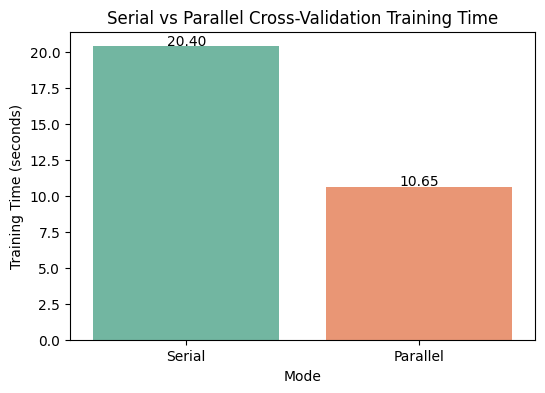

In [44]:
plt.figure(figsize=(6, 4))
sns.barplot(x='Mode', y='Training Time (sec)', data=comparison_df, palette='Set2')

plt.title('Serial vs Parallel Cross-Validation Training Time')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Mode')

for index, row in comparison_df.iterrows():
    plt.text(index, row['Training Time (sec)'] + 0.1, f"{row['Training Time (sec)']:.2f}", ha='center')

plt.show()

# **Stratified K-Fold Cross-Validation with Mean F1 for Logistic Regression**

In [35]:
# Define the pipeline
lr_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# Run Stratified K-Fold CV with your defined scoring
lr_cv_results = cross_validate(lr_pipeline, X, y, cv=kf, scoring=scoring)

print("\nLogistic Regression Cross Validation (with SMOTE):")
print(f"F1 scores: {lr_cv_results['test_f1']}")
print(f"Precision scores: {lr_cv_results['test_precision']}")
print(f"Recall scores: {lr_cv_results['test_recall']}")
print(f"Mean F1: {lr_cv_results['test_f1'].mean():.4f}, Std: {lr_cv_results['test_f1'].std():.4f}")
print(f"Mean Precision: {lr_cv_results['test_precision'].mean():.4f}")
print(f"Mean Recall: {lr_cv_results['test_recall'].mean():.4f}")



Logistic Regression Cross Validation (with SMOTE):
F1 scores: [0.79045093 0.80079418 0.78860172 0.80239521 0.79625919]
Precision scores: [0.6819222  0.69063927 0.68077803 0.69470046 0.69141531]
Recall scores: [0.94006309 0.95275591 0.93700787 0.9496063  0.93858268]
Mean F1: 0.7957, Std: 0.0055
Mean Precision: 0.6879
Mean Recall: 0.9436


# **Comparing the Random Forest and Logistic Regression Models**

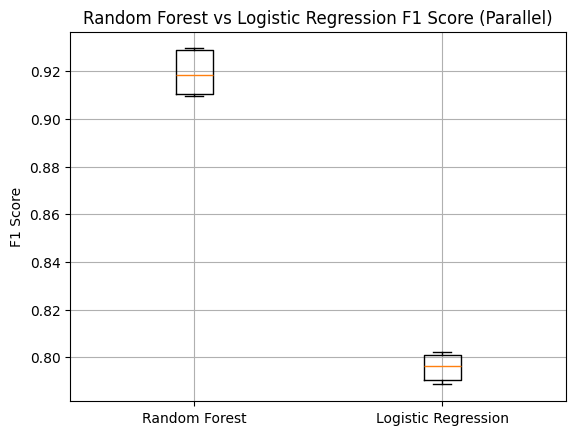

In [36]:
plt.boxplot(
    [rf_cv_parallel['test_f1'], lr_cv_results['test_f1']],
    labels=['Random Forest', 'Logistic Regression']
)
plt.title('Random Forest vs Logistic Regression F1 Score (Parallel)')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# **Feature Importances For the Two models used**

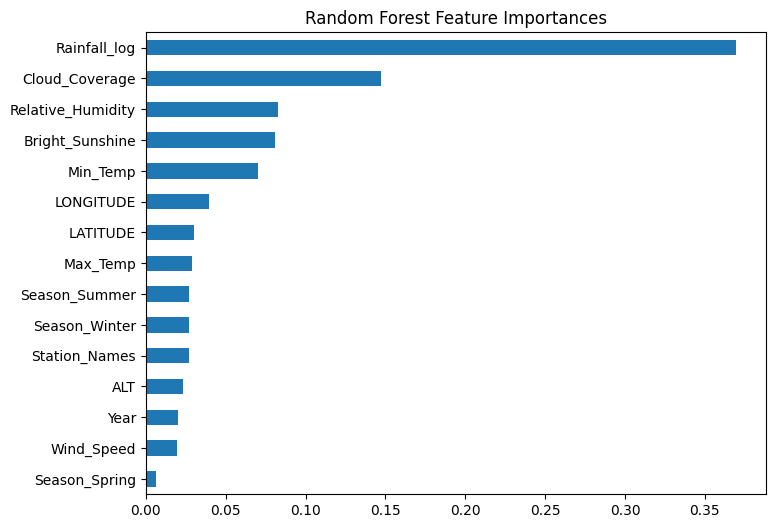

In [37]:
rf_trained = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_trained.fit(X_train, y_train)

importances = pd.Series(rf_trained.feature_importances_, index=X_train.columns).sort_values()
importances.plot(kind='barh', figsize=(8,6))
plt.title("Random Forest Feature Importances")
plt.show()

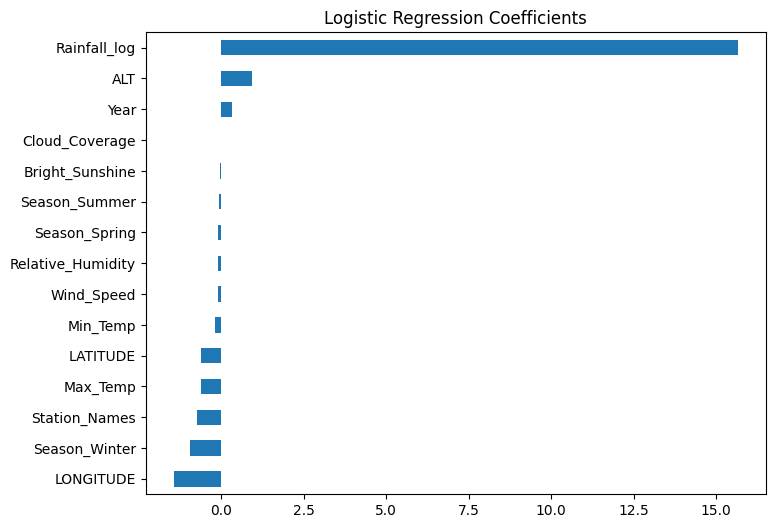

In [38]:
# Logistic Regression coefficients (trained on SMOTE + scaled data)
coefs = pd.Series(lr.coef_[0], index=features).sort_values()
coefs.plot(kind='barh', figsize=(8,6))
plt.title("Logistic Regression Coefficients")
plt.show()